### Import libraries

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

### Define helper functions

In [2]:
def spectrogram(x, win_len=400, hop_len=160, n_fft=256):
    '''
    spectrogram
    
    Inputs
    ------
    x: shape(N_f, ) - raw signal
    win_len: int - window length in frames
    hop_len: int - hop length in frames
    n_fft: int - number of fft points
    
    Returns
    -------
    xf: shape(N_f, 128) - spectrogram
    '''
    # calculate number of frames
    n_frames = 1 + np.int(np.floor((len(x) - win_len) / float(hop_len)))
    xf = np.zeros((n_frames, 256), np.complex64)
    # perform sliding window operation
    for i in range(n_frames):
        z = x[i * hop_len: i * hop_len + win_len] * np.hamming(win_len)
        xf[i] = np.fft.fft(z, n=n_fft)
    # obtain log of the absolute values of the features
    xf = np.log(np.abs(xf[:, :(n_fft) // 2]))
    return xf

In [3]:
def whitening(X):
    '''
    compute whitening matrix
    
    Input
    ------
    X: shape(N, F) - feature matrix with zero mean
    
    Returns
    -------
    W: whitening matrix
    '''
    # perform SVD decomposition
    U, S, Vt = np.linalg.svd(X, full_matrices=True)
    # find transformation matrix W
    W = Vt.T / S * np.sqrt(X.shape[0] - 1)
    return W

### Load files

In [4]:
# Here we are analysing the performance of whitening transform
# computed from the 'clean' audio file. It is expected that you 
# can modify the code and perform the analysis when the 
# transformation is computed from the 'noisy' audio file.
y_clean, sr = librosa.load('speechFiles/clean.wav', sr=None)
y_noisy, sr = librosa.load('speechFiles/noisy.wav', sr=None)

### Obtain spectrogram

In [5]:
clean_spec = spectrogram(y_clean)
noisy_spec = spectrogram(y_noisy)

### Mean and standard deviation normalization

In [6]:
mean = clean_spec.mean(axis=0)
std = clean_spec.std(axis=0)

clean_spec = (clean_spec - mean) / std
noisy_spec = (noisy_spec - mean) / std

### Apply whitening transform

In [7]:
W = whitening(clean_spec)
clean_spec_white = clean_spec @ W
noisy_spec_white = noisy_spec @ W

### Find the sampled covariance matrices

In [8]:
clean_spec_cov = np.cov(clean_spec.T)
clean_spec_white_cov = np.cov(clean_spec_white.T)

noisy_spec_cov = np.cov(noisy_spec.T)
noisy_spec_white_cov = np.cov(noisy_spec_white.T)

### Visualize whitening transform

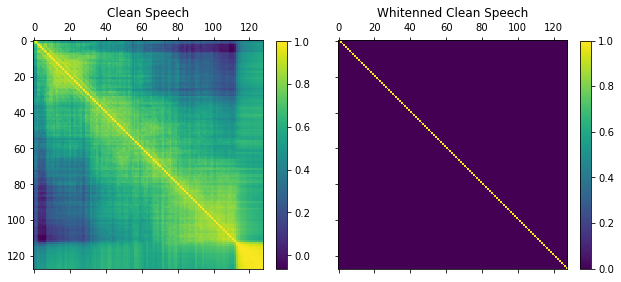

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), sharey=True)
f1 = ax[0].matshow(clean_spec_cov)
f2 = ax[1].matshow(clean_spec_white_cov)
ax[0].set_title('Clean Speech')
ax[1].set_title('Whitenned Clean Speech')
fig.colorbar(f1, ax=ax[0], fraction=0.045)
fig.colorbar(f2, ax=ax[1], fraction=0.045)

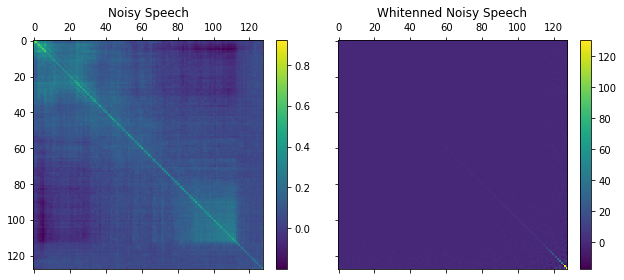

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), sharey=True)
f1 = ax[0].matshow(noisy_spec_cov)
f2 = ax[1].matshow(noisy_spec_white_cov)
ax[0].set_title('Noisy Speech')
ax[1].set_title('Whitenned Noisy Speech')
fig.colorbar(f1, ax=ax[0], fraction=0.045)
fig.colorbar(f2, ax=ax[1], fraction=0.045)

### Better Visualization for Noisy Speech

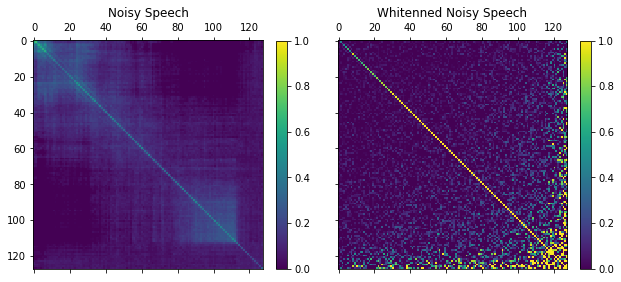

In [11]:
# here we will specify the color range for the plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), sharey=True)
f1 = ax[0].matshow(noisy_spec_cov, vmin=0, vmax=1)
f2 = ax[1].matshow(noisy_spec_white_cov, vmin=0, vmax=1)
ax[0].set_title('Noisy Speech')
ax[1].set_title('Whitenned Noisy Speech')
fig.colorbar(f1, ax=ax[0], fraction=0.045)
fig.colorbar(f2, ax=ax[1], fraction=0.045)

### Average absolute value of the non-diagonal entries

In [12]:
clean_abs_val = np.mean(np.abs(clean_spec_cov - np.diag(np.diag(clean_spec_cov))))
noisy_abs_val = np.mean(np.abs(noisy_spec_cov - np.diag(np.diag(noisy_spec_cov))))

clean_white_abs_val = np.mean(np.abs(clean_spec_white_cov - np.diag(np.diag(clean_spec_white_cov))))
noisy_white_abs_val = np.mean(np.abs(noisy_spec_white_cov - np.diag(np.diag(noisy_spec_white_cov))))

In [13]:
clean_abs_val, noisy_abs_val

(0.5676937157376443, 0.08594689381297194)

In [14]:
clean_white_abs_val, noisy_white_abs_val

(2.3977107982717105e-08, 0.1570702129631799)

### Observation

We see that the sampled covariance matrix of the whitenned 'clean' file is almost an Identity matrix, with the off-diagonal elements having an average close to zero. This suggests that the features have been made uncorrelated.

Whereas, the same transformation when applied to 'noisy' file fails to generate an Identity matrix as the sampled covariance matrix, suggesting that the features are still correlated.

The transformation is thus specific to a given dataset, from which it has been computed.